In [4]:
import numpy as np
import pandas as pd

In [5]:
pose_3d_path = "/home/talmolab/vast/scott-yang/data/fly-testing/summaries/pose_3d.csv"
calibration_path = (
    "/home/talmolab/vast/scott-yang/data/fly-testing/Calibration/calibration.toml"
)
df = pd.read_csv(pose_3d_path)
fly_path = "/home/talmolab/vast/scott-yang/data/fly-testing"

In [28]:
# Load the ground truth 2D pose data for comparison
pose_2d_path = (
    Path(fly_path) / folder_1 / "pose-2d" / (video_filename.replace(".mp4", ".h5"))
)
print(f"Loading ground truth 2D poses from: {pose_2d_path}")

if pose_2d_path.exists():
    with h5py.File(pose_2d_path, "r") as f:
        # Print available datasets in the HDF5 file

        # Load the tracks data
        tracks = f["df_with_missing"]["table"][:]
        print(f"Tracks shape: {tracks.shape}")
        print(f"Track data for frame {frame_num}:")

        # Extract 2D points for the current frame
        gt_pts2d = tracks[frame_num, 0, :, :]  # [frame, instance, keypoint, xy]
        print(f"Ground truth 2D points shape: {gt_pts2d.shape}")
else:
    print(f"Ground truth file not found: {pose_2d_path}")

Loading ground truth 2D poses from: /home/talmolab/vast/scott-yang/data/fly-testing/Fly 1_0/pose-2d/05272019_fly1_0 R1C11 Cam-D str-ccw-0.09 sec.h5
Tracks shape: (601,)
Track data for frame 100:


IndexError: too many indices for array: array is 1-dimensional, but 4 were indexed

In [7]:
import cv2
import matplotlib.pyplot as plt
import sleap_anipose as slap
import h5py
from pathlib import Path

# Select a single row from the dataframe
row_idx = 100  # Change this to select different frames
row = df.iloc[row_idx]

# Extract metadata
folder_1 = row["folder_1"]
filename = row["filename"]
frame_num = int(row["fnum"])

print(f"Processing: {filename}, frame {frame_num}")
print(f"Folder: {folder_1}")

Processing: 05272019_fly1_0 R1C11  str-ccw-0.09 sec, frame 100
Folder: Fly 1_0


In [8]:
# Extract 3D keypoints from the row (all *_x, *_y, *_z columns except center)
keypoint_cols = [
    col
    for col in df.columns
    if col.endswith(("_x", "_y", "_z"))
    and not col.startswith("center")
    and not col.startswith("M_")
]

# Get unique keypoint names
keypoint_names = sorted(list(set([col.rsplit("_", 1)[0] for col in keypoint_cols])))
print(f"Found {len(keypoint_names)} keypoints: {keypoint_names[:10]}...")

# Build 3D points array [1, 1, N, 3] format
n_keypoints = len(keypoint_names)
p3d = np.zeros((1, 1, n_keypoints, 3))

for i, kp_name in enumerate(keypoint_names):
    p3d[0, 0, i, 0] = row[f"{kp_name}_x"]
    p3d[0, 0, i, 1] = row[f"{kp_name}_y"]
    p3d[0, 0, i, 2] = row[f"{kp_name}_z"]

print(f"p3d shape: {p3d.shape}")

Found 30 keypoints: ['L1A', 'L1B', 'L1C', 'L1D', 'L1E', 'L2A', 'L2B', 'L2C', 'L2D', 'L2E']...
p3d shape: (1, 1, 30, 3)


In [9]:
# Use sleap_anipose to compute 2D reprojections
reprojections = slap.reproject(
    p3d=p3d,
    calib=calibration_path,
)

print(f"Reprojections shape: {len(reprojections)} cameras")
for i, cam_reproj in enumerate(reprojections):
    print(f"  Camera {i}: {cam_reproj.shape}")

Reprojections shape: 6 cameras
  Camera 0: (1, 1, 30, 2)
  Camera 1: (1, 1, 30, 2)
  Camera 2: (1, 1, 30, 2)
  Camera 3: (1, 1, 30, 2)
  Camera 4: (1, 1, 30, 2)
  Camera 5: (1, 1, 30, 2)


In [29]:
# Select a camera to visualize (e.g., Cam-A = 0, Cam-B = 1, etc.)
camera_idx = 0  # Change this to select different cameras
camera_letter = chr(65 + camera_idx)  # A, B, C, D, E...

# Build video path from the filename in dataframe
# The dataframe has base filename, videos add "Cam-X" between the identifier and the last part
# e.g., "05272019_fly1_0 R1C11  str-ccw-0.09 sec" -> "05272019_fly1_0 R1C11 Cam-A str-ccw-0.09 sec.mp4"
filename_parts = filename.split()
# Insert "Cam-X" after the second part (which is the identifier like "R1C11")
video_filename_parts = (
    filename_parts[:2] + [f"Cam-{camera_letter}"] + filename_parts[2:]
)
video_filename = " ".join(video_filename_parts) + ".mp4"
video_path = Path(fly_path) / folder_1 / "videos-raw-compressed" / video_filename

print(f"Video path: {video_path}")
print(f"Video exists: {video_path.exists()}")

# Load the video frame
if not video_path.exists():
    print("ERROR: Video file not found!")
else:
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print("ERROR: Could not open video!")
    else:
        # Seek to the frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame_bgr = cap.read()
        cap.release()

        if not ret:
            print(f"ERROR: Could not read frame {frame_num}")
        else:
            frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            print(f"Frame shape: {frame_rgb.shape}")

Video path: /home/talmolab/vast/scott-yang/data/fly-testing/Fly 1_0/videos-raw-compressed/05272019_fly1_0 R1C11 Cam-A str-ccw-0.09 sec.mp4
Video exists: True
Frame shape: (450, 528, 3)


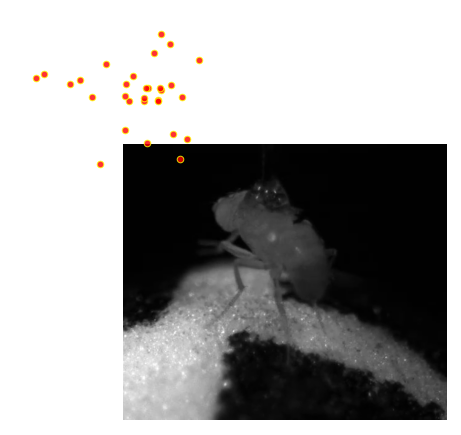

Plotted 30 / 30 keypoints


In [30]:
# Extract 2D reprojections for this camera and frame
pts2d = reprojections[camera_idx][0, 0, :, :]  # Shape: [N, 2]

# Plot the frame with keypoint overlay
H, W = frame_rgb.shape[:2]
fig, ax = plt.subplots(figsize=(W / 150, H / 150), dpi=150)
ax.imshow(frame_rgb)
ax.set_axis_off()

# Plot keypoints
xs = pts2d[:, 0]
ys = pts2d[:, 1]

# Filter out NaN values
valid = ~np.isnan(xs) & ~np.isnan(ys)
ax.scatter(
    xs[valid], ys[valid], c="red", s=10, alpha=0.8, edgecolors="yellow", linewidths=0.5
)

plt.tight_layout()
plt.show()

print(f"Plotted {valid.sum()} / {len(pts2d)} keypoints")

Sample filenames from dataframe:
                                  filename folder_1
0  05272019_fly1_0 R1C11  str-ccw-0.09 sec  Fly 1_0
1  05272019_fly1_0 R1C11  str-ccw-0.09 sec  Fly 1_0
2  05272019_fly1_0 R1C11  str-ccw-0.09 sec  Fly 1_0
3  05272019_fly1_0 R1C11  str-ccw-0.09 sec  Fly 1_0
4  05272019_fly1_0 R1C11  str-ccw-0.09 sec  Fly 1_0
5  05272019_fly1_0 R1C11  str-ccw-0.09 sec  Fly 1_0
6  05272019_fly1_0 R1C11  str-ccw-0.09 sec  Fly 1_0
7  05272019_fly1_0 R1C11  str-ccw-0.09 sec  Fly 1_0
8  05272019_fly1_0 R1C11  str-ccw-0.09 sec  Fly 1_0
9  05272019_fly1_0 R1C11  str-ccw-0.09 sec  Fly 1_0


Actual video files in directory:
  05272019_fly1_0 R1C11 Cam-A str-ccw-0.09 sec.mp4
  05272019_fly1_0 R1C11 Cam-B str-ccw-0.09 sec.mp4
  05272019_fly1_0 R1C11 Cam-C str-ccw-0.09 sec.mp4
  05272019_fly1_0 R1C11 Cam-D str-ccw-0.09 sec.mp4
  05272019_fly1_0 R1C11 Cam-E str-ccw-0.09 sec.mp4
